In [1]:
%load_ext autoreload
%autoreload 2

# EDA
We will go through EDA with the help of [this notebook](https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert/notebook) from Kaggle, by [Gunes Evitan](https://www.kaggle.com/gunesevitan)

In [2]:
from sklearn.datasets import fetch_20newsgroups
all_xs, all_y = fetch_20newsgroups(subset="all", remove=('headers', 'footers', 'quotes'),
                    shuffle=True, return_X_y=True)

In [3]:
len(all_xs)

18846

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from pathlib import Path
from fastai.text.all import *

plt.rcParams["figure.dpi"] = 100

In [5]:
import sys
# NOTE: you NEED to change PATH yourself manually, for now. 
path = Path("/home/fastai2/notebooks/DataGlacier")  
sys.path.append(str(path/"NLP_GroupProject_DG/python_files"))

In [6]:
from nlputils import split_data, stoi

In [7]:
# We'll do some further cleaning later on. 
df = pd.DataFrame([all_xs, all_y]).T
df.columns = ["text", "category"]
df.head(2)

,text,category
0,"\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out o...",10
1,My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM. Does anyone have suggestions/ideas on:\n\n - Diamond Stealth Pro Local Bus\n\n - Orchid Farenheit 1280\n\n - ATI Graphics Ultra Pro\n\n - Any other high-performance VLB card\n\n\nPlease post or email. Thank you!\n\n - Matt\n,3


## Cleaning out for non-useful data
These are the ones that are one-off. E.g. they contains pure coordinates, pure programming code, pure german language, etc. Previously we did this and saved the data, but only if we choose those data with sentence higher than threshold then we can use that here. Since we're using the full data here, we shall do the cleaning again. We shall build the `DataLoaders` from original code, to imitate the originals as close as possible. 

In [8]:
sl = 72  # seq_len

try: tok = load_pickle("tok.pkl")
except Exception:
    dls = DataBlock(
        blocks=(TextBlock.from_df("text", seq_len=sl, tok=SpacyTokenizer("en")),
                CategoryBlock),
        get_x=ColReader("text"), get_y=ColReader("category"),
        splitter=RandomSplitter(0.1)
    ).dataloaders(df, bs=32, num_workers=os.cpu_count(), seq_len=sl)

    save_pickle("tok.pkl", dls.tok)
    tok = dls.tok

In [9]:
df_tok, unique_words = tokenize_df(df, "text", tok=tok)
df_tok[["category", "text", "text_length"]].head(2)

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,category,text,text_length
0,10,"[xxbos, i, am, sure, some, bashers, of, xxmaj, pens, fans, are, pretty, confused, about, the, lack, \n, of, any, kind, of, posts, about, the, recent, xxmaj, pens, massacre, of, the, xxmaj, devils, ., xxmaj, actually, ,, \n, i, am, bit, puzzled, too, and, a, bit, relieved, ., xxmaj, however, ,, i, am, going, to, put, an, end, \n, to, non, -, pittsburghers, ', relief, with, a, bit, of, praise, for, the, xxmaj, pens, ., xxmaj, man, ,, they, \n, are, killing, those, xxmaj, devils, worse, than, i, thought, ., xxmaj, jagr, just, showed, you, why, \n, he, is, much, better, ...]",179
1,3,"[xxbos, xxmaj, my, brother, is, in, the, market, for, a, high, -, performance, video, card, that, supports, \n, xxup, vesa, local, bus, with, 1, -, 2, mb, xxup, ram, ., xxmaj, does, anyone, have, suggestions, /, ideas, on, :, \n\n▁, -, xxmaj, diamond, xxmaj, stealth, xxmaj, pro, xxmaj, local, xxmaj, bus, \n\n▁, -, xxmaj, orchid, xxmaj, farenheit, 1280, \n\n▁, -, xxup, ati, xxmaj, graphics, xxmaj, ultra, xxmaj, pro, \n\n▁, -, xxmaj, any, other, high, -, performance, xxup, vlb, card, \n\n\n, xxmaj, please, post, or, email, ., xxmaj, thank, you, !, \n\n▁, -, xxmaj, matt]",94


In [10]:
try: choice = np.load("choice.npy")
except Exception:
    choice = np.zeros((len(df_tok), )).astype(np.float32)
    loop_over = df_tok["text"].to_numpy()

    vocab = dls.vocab[0]
    for k, data in enumerate(tqdm(loop_over)):
        x = stoi(vocab, data)

        # Total number of xxunk / total number of words. 
        choice[k] = (x == 0).sum() / len(x)

    del loop_over, vocab, x, data
    gc.collect()
    np.save("choice", choice)

In [11]:
del_thres = choice < 0.25
df = df[del_thres].reset_index(level=0, drop=True)
df_tok = df_tok[del_thres].reset_index(level=0, drop=True)

In [12]:
len(df)

18794

Parallel compute using joblib threads takes: 3 min 07 sec.  
Singular compute using for-loop takes: 2 min 38.8 sec. 

### Let's continue with data analysis

In [13]:
df[df.category == 10].head(2)

,text,category
0,"\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out o...",10
7,"\n[stuff deleted]\n\nOk, here's the solution to your problem. Move to Canada. Yesterday I was able\nto watch FOUR games...the NJ-PITT at 1:00 on ABC, LA-CAL at 3:00 (CBC), \nBUFF-BOS at 7:00 (TSN and FOX), and MON-QUE at 7:30 (CBC). I think that if\neach series goes its max I could be watching hockey playoffs for 40-some odd\nconsecutive nights (I haven't counted so that's a pure guess).\n\nI have two tv's in my house, and I set them up side-by-side to watch MON-QUE\nand keep an eye on BOS-BUFF at the same time. I did the same for the two\nafternoon games.\n\nBtw, those ABC commentater...",10


Line numbers count and "potentially" word count.

In [14]:
%%time
df["word_count"] = df["text"].apply(lambda x: len(str(x).split()))
df["line_count"] = df["text"].apply(lambda x: len(split_data(str(x))))

CPU times: user 361 ms, sys: 4.02 ms, total: 365 ms
Wall time: 364 ms


In [15]:
df.head()

,text,category,word_count,line_count
0,"\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out o...",10,137,9
1,My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM. Does anyone have suggestions/ideas on:\n\n - Diamond Stealth Pro Local Bus\n\n - Orchid Farenheit 1280\n\n - ATI Graphics Ultra Pro\n\n - Any other high-performance VLB card\n\n\nPlease post or email. Thank you!\n\n - Matt\n,3,53,8
2,"\n\n\n\n\tFinally you said what you dream about. Mediterranean???? That was new....\n\tThe area will be ""greater"" after some years, like your ""holocaust"" numbers......\n\n\n\n\n\t\t*****\n\tIs't July in USA now????? Here in Sweden it's April and still cold.\n\tOr have you changed your calendar???\n\n\n\t\t\t\t\t\t ****************\n\t\t\t\t\t\t ******************\n\t\t\t ***************\n\n\n\tNOTHING OF THE MENTIONED IS TRUE, BUT LET SAY IT's TRUE.\n\t\n\tSHALL THE AZERI WOMEN AND CHILDREN GOING TO PAY THE PRICE WITH\n\t\t\t\t\t\t **************\n\tBEING RAPED, KILLED AND TORT...",17,241,38
3,\nThink!\n\nIt's the SCSI card doing the DMA transfers NOT the disks...\n\nThe SCSI card can do DMA transfers containing data from any of the SCSI devices\nit is attached when it wants to.\n\nAn important feature of SCSI is the ability to detach a device. This frees the\nSCSI bus for other devices. This is typically used in a multi-tasking OS to\nstart transfers on several devices. While each device is seeking the data the\nbus is free for other commands and data transfers. When the devices are\nready to transfer the data they can aquire the bus and send the data.\n\nOn an IDE bus when you...,3,144,12
4,"1) I have an old Jasmine drive which I cannot use with my new system.\n My understanding is that I have to upsate the driver with a more modern\none in order to gain compatability with system 7.0.1. does anyone know\nof an inexpensive program to do this? ( I have seen formatters for <$20\nbuit have no idea if they will work)\n \n2) I have another ancient device, this one a tape drive for which\nthe back utility freezes the system if I try to use it. THe drive is a\njasmine direct tape (bought used for $150 w/ 6 tapes, techmar\nmechanism). Essentially I have the same question as ...",4,125,11


<AxesSubplot:xlabel='word_count', ylabel='Count'>

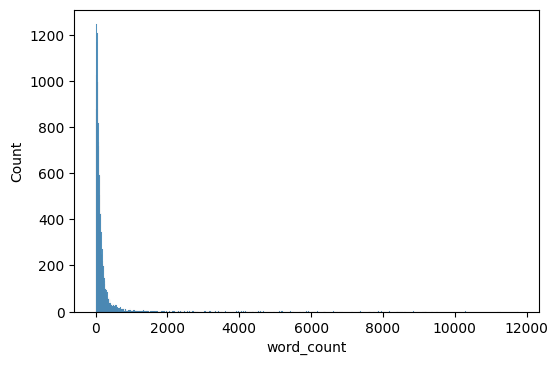

In [16]:
sns.histplot(df["word_count"])

Looks like word count we have a very long tail (and very means very very very...). Most of the data are short, and perhaps they're more representative? 

For example, previously we take a threshold which says: *for data less than this number of lines, we discard it*. Perhaps we should have been doing the other way round: *for data more than certain number of lines, we discard it* is the better way! 

We have updated `threshold_subset` to include an arg called `geq` to do this. 

<AxesSubplot:xlabel='word_count', ylabel='Count'>

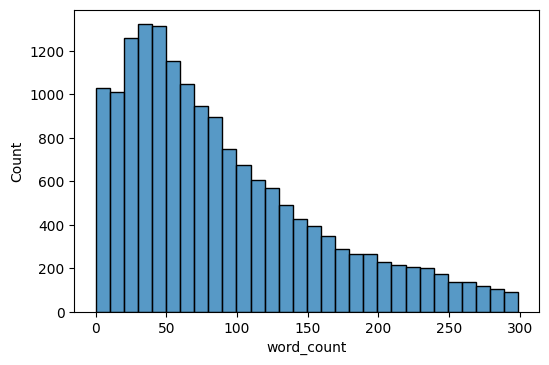

In [17]:
sns.histplot(df[df["word_count"] < 300]["word_count"], bins=30)

<AxesSubplot:xlabel='line_count', ylabel='Count'>

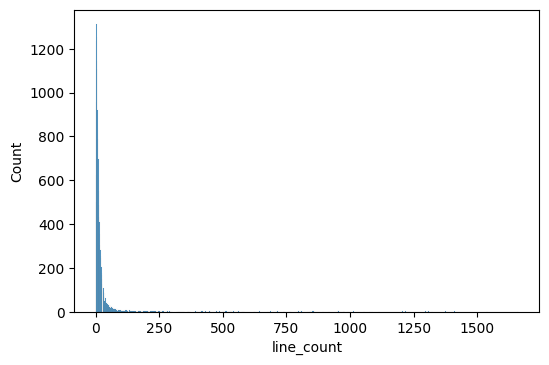

In [18]:
sns.histplot(df["line_count"])

<AxesSubplot:xlabel='line_count', ylabel='Count'>

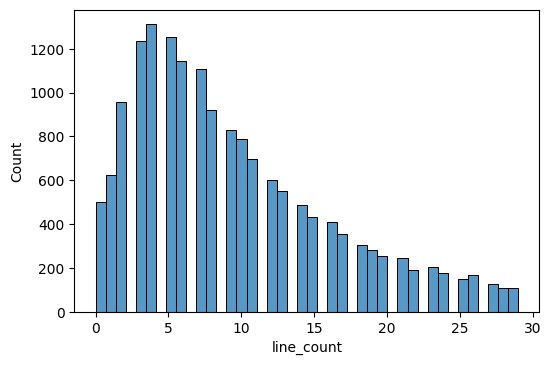

In [19]:
sns.histplot(df[df.line_count < 30].line_count)

### Food for thoughts:
- This is NLP, not Tabular data. Do you think it's better to remove data that are outliers? 
- Do you think really most of the information are aggregated in the long articles? Or most in short articles? What are their differences? 

These are not something that you can visualize using graphs. Honestly to deal with them, EDA isn't the best way. There are 2 ways to do: 
- EDA: **manually** read the paragraphs yourself and determine whether they're useful or not, either by yourself, with a group, via debate, or any other means to make decisions. 
- ML: Train a model with and without certain group, and see how does the loss do. And make decisions based on loss, accuracy, or any other metrics we define to meet our needs. (Black box decision making).

The latter being a faster decision maker, and more useful if you would like to optimize for better ML results making rather than understanding. 

Let us continue next and look at stop word count, and we also do unique word count. 

In [20]:
from sklearn.feature_extraction import _stop_words
STOPWORDS = _stop_words.ENGLISH_STOP_WORDS

In [21]:
df["stop_word_count"] = df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

In [22]:
df.head(2)

,text,category,word_count,line_count,stop_word_count
0,"\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out o...",10,137,9,72
1,My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM. Does anyone have suggestions/ideas on:\n\n - Diamond Stealth Pro Local Bus\n\n - Orchid Farenheit 1280\n\n - ATI Graphics Ultra Pro\n\n - Any other high-performance VLB card\n\n\nPlease post or email. Thank you!\n\n - Matt\n,3,53,8,14


<AxesSubplot:xlabel='stop_word_count', ylabel='Count'>

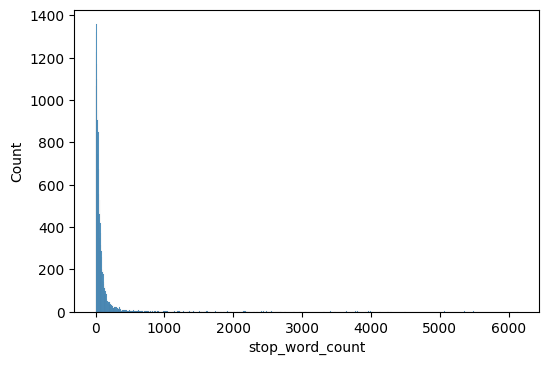

In [23]:
sns.histplot(df["stop_word_count"])

<AxesSubplot:xlabel='stop_word_count', ylabel='Count'>

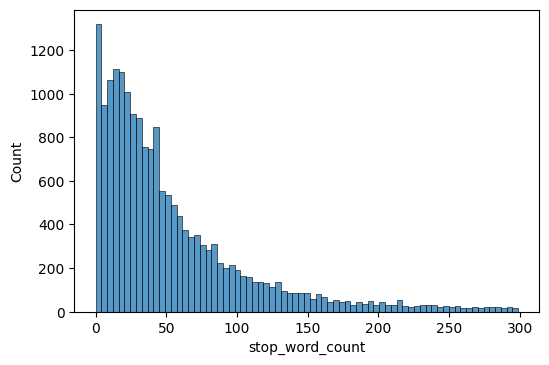

In [24]:
sns.histplot(df[df.stop_word_count < 300].stop_word_count)

### Stop words count / word count (ratio)

In [25]:
df["stop_word_ratio"] = df.stop_word_count / df.word_count
print((df.stop_word_ratio.isna()).sum())
df["stop_word_ratio"].fillna(0, inplace=True)

515


In [26]:
print("Median: ", df.stop_word_ratio.median())
print("Mean: ", df.stop_word_ratio.mean())
print("Std: ", df.stop_word_ratio.std())

Median:  0.4745762711864407
Mean:  0.443714166539526
Std:  0.13075392883348091


<AxesSubplot:xlabel='stop_word_ratio', ylabel='Count'>

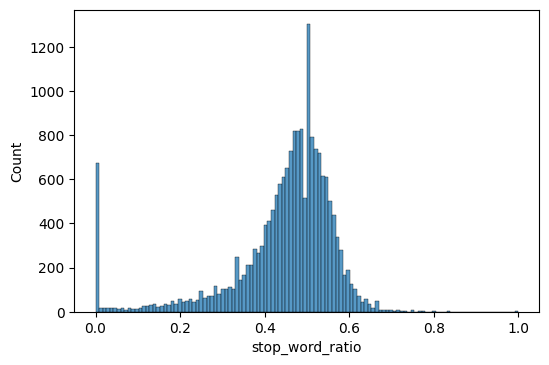

In [27]:
sns.histplot(df.stop_word_ratio)

In [28]:
(df["stop_word_ratio"] == 1).sum()

2

The only reason why we have quite high 0 is because we have 515 that have word count = 0. This means these are the "broken articles" that doesn't have space in between.  
We want to see which are max, for 100 percentile. Hence, we need to round all floats to 2 decimal places first. 

In [29]:
df["stop_word_ratio"] = df["stop_word_ratio"].apply(lambda x: round(x, 2))
Counter(df.stop_word_ratio).most_common(5)

[(0.5, 1223), (0.47, 980), (0.48, 951), (0.51, 940), (0.49, 919)]

Somewhat like Gaussian but more heavily weighted at the left side. It's almost impossible for the entire set of sentences to be made of stop words, but it's somewhat likely (much much more likely compared to everything being stop words, although not impossible) that there are no stop words present in the data as well. 

## Punctuation Count
Let's look a bit at punctuation count. 

In [30]:
import string
df["punctuation_count"] = df["text"].apply(lambda x: len([c for c in str(x)
                                if c in string.punctuation]))

<AxesSubplot:xlabel='punctuation_count', ylabel='Count'>

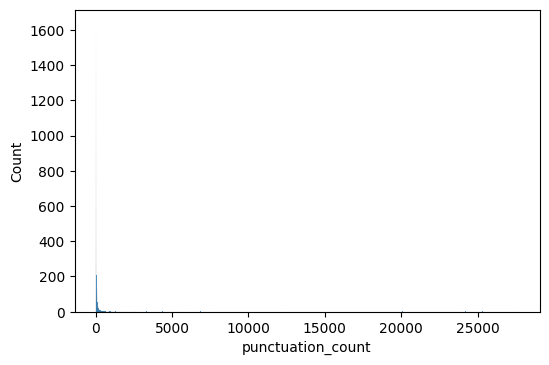

In [31]:
sns.histplot(df.punctuation_count)

As usual that doesn't tell much. We can divide them by the number of words to get a ratio as well. 

In [32]:
df["punctuation_ratio"] = df.punctuation_count / df.word_count
print((df.punctuation_count.isna()).sum())
df["punctuation_ratio"].fillna(0, inplace=True)

0


So it's true that when we don't have words, we don't have punctuations. Or we would get NaNs. 

<AxesSubplot:xlabel='punctuation_ratio', ylabel='Count'>

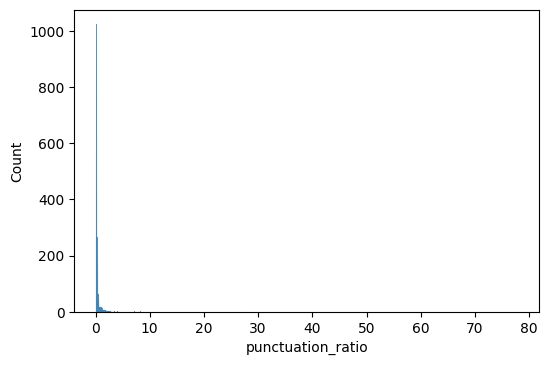

In [33]:
sns.histplot(df.punctuation_ratio)

There are quite a wide range (long tail), but overall it's not too many for most of the data. Perhaps those are the outliers that we'll clean away later on. We'll get back to counting stop words and punctuations after we clean the data later on at the end. 

<AxesSubplot:xlabel='punctuation_ratio', ylabel='Count'>

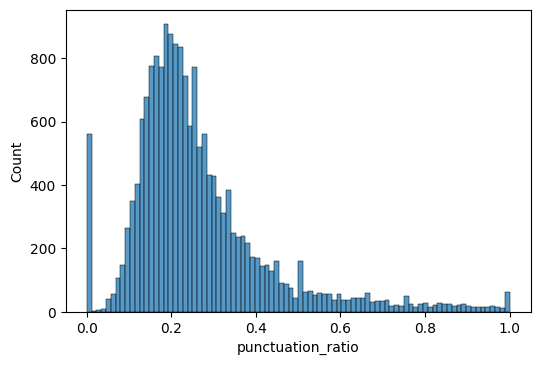

In [34]:
sns.histplot(df[df.punctuation_ratio <= 1].punctuation_ratio)

### Let's look at the unique words a bit.

In [35]:
unique_words.most_common(50)

[('xxmaj', 398490),
 ('\n', 226834),
 (',', 173896),
 ('the', 173555),
 ('.', 172199),
 ('xxup', 132119),
 ('to', 86846),
 ('of', 77161),
 ('a', 70645),
 ('and', 70035),
 ('i', 56893),
 ('\n▁', 53948),
 ('-', 52311),
 ('in', 50811),
 ('is', 49977),
 ('that', 46006),
 (')', 45216),
 ('"', 43028),
 ('\n\n', 42575),
 ('(', 41654),
 ('it', 38539),
 ('/', 37311),
 (':', 34311),
 ('for', 32286),
 ('you', 30474),
 ('?', 23910),
 ('on', 23587),
 ('this', 23493),
 ('be', 21992),
 ('have', 21899),
 ('not', 21489),
 ('are', 21359),
 ('with', 20888),
 ('>', 19569),
 ("'s", 19335),
 ('#', 18943),
 ('xxbos', 18846),
 ('as', 18717),
 ('or', 17336),
 ("n't", 17085),
 ("'", 16991),
 ('xxrep', 16523),
 ('\\', 16475),
 ('was', 16377),
 ('do', 15880),
 ('if', 15746),
 ('*', 15699),
 ('but', 15531),
 ('they', 15273),
 ('from', 13555)]

This isn't too explaining actually. But we can see some words appears quite often, but they didn't really distinguish between different categories, seriously speaking. Capital letters `xxmaj` seems to flood the articles, even more than punctuations like full stop. 

Also note that this counter is expired. We count it when we still have the dirty data, but now we have one pass through to clean those with lots of xxunk (threshold value 0.25). 

However, we may get some insights if we get the max number of counts after we split the data based on their categories. 

In [36]:
tok_text = df_tok["text"].to_numpy()
tok_text.shape

(18794,)

In [37]:
sorted(df_tok.category.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [38]:
import gc
from tqdm.notebook import tqdm
from collections import Counter
import joblib

In [39]:
def cat_counter(df_tok):
    """
    Counter of most frequent words based on category. 
    Sorted by category already. 
    """
    cache = []  # {}

    # def inner_(cat): 
    #     counter = Counter()
    #     temp_np = df_tok[df_tok.category == cat].text.to_numpy()
    #     for sentence in temp_np: counter += Counter(sentence)
    #     cache[cat] = counter
    #     del counter, temp_np, sentence

    # _ = joblib.Parallel(n_jobs=os.cpu_count(), prefer="threads")(
    #     joblib.delayed(inner_)(cat)
    #     for cat in tqdm(range(20))
    # )

    for cat in tqdm(range(20)):  # sorted
        counter = Counter()
        temp_np = df_tok[df_tok.category == cat].text.to_numpy()
        for sentence in temp_np: counter += Counter(sentence)
        # cache[cat] = counter
        cache.append(counter)
        del counter, temp_np, sentence
    gc.collect()
    return cache

In [40]:
counters = cat_counter(df_tok)

  0%|          | 0/20 [00:00<?, ?it/s]

In [41]:
import re
from tabulate import tabulate
from IPython.display import display, HTML

In [42]:
def print_top_k_common(counters, k=10, return_val=False, to_be_deleted=None):
    """
    Display top k words with html table. 

    :return_val: (bool) Whether to return result or not. Default: False. 
    :to_be_deleted: (list) What to exclude from count. Default: None
        (so only xxmaj excluded. )
    """
    r = re.compile(r'\n+')
    to_del = ["xxmaj"]
    if to_be_deleted is None: to_be_deleted = to_del
    else: to_be_deleted += to_del
    # +50 to replace the ones in the line marked **. Have caveats. 
    # only works as long as you don't exhaust the below. 
    top_k = [counter.most_common(k+len(to_be_deleted)+50) for counter in counters]
    top_k = [np.array([list(word) for word in counter])
                for counter in top_k]
    for i in range(len(top_k)): 
        a = top_k[i][:, 0]
        to_be_deleted += list(set(filter(r.match, a)))  # **
        for d in to_be_deleted: a = np.delete(a, np.where(a == d))
        if len(a) > k: a = a[:k]
        top_k[i] = [i] + list(a)
        

    display(HTML(tabulate(top_k, 
                    headers=["category", *range(k)],
                    tablefmt="html")))
    if return_val: return top_k

In [43]:
m = print_top_k_common(counters, 15, True, 
    to_be_deleted=""". , " ' / # \\ = : - ( ) ; * ▁ to and xxup i a of the
                    you that in xxbos is it for not ? ! … `
                    this with have but if n't they was are as or
                    be at on were he 's we""".split())

category,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,do,>,what,an,by,one,can,so,god,there,your,all,from,no,would
1,xxrep,image,from,can,jpeg,graphics,an,do,3,by,will,],file,there,[
2,>,<,max>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax,_,windows,],g9v,m,w,p,$,xxrep,t,g)r,do
3,xxrep,my,drive,can,do,3,an,any,from,2,there,card,will,one,would
4,can,my,xxrep,do,mac,from,an,apple,3,what,one,would,any,has,there
5,x,xxrep,3,,can,an,from,do,by,window,file,use,your,>,$
6,$,1,2,xxrep,3,all,,new,4,me,sale,,5,will,one
7,car,my,xxrep,do,about,3,there,would,can,from,an,all,your,out,so
8,my,do,bike,xxrep,your,me,about,one,from,so,there,>,all,would,out
9,3,xxrep,1,do,his,4,0,would,2,year,,game,has,so,out


You notice something like `n't` because fastai knows that a word such as `don't` should be split up (just like stemming and lemmatization) into `do` and `n't`. The contractions aren't split into full by fastai's method. 

In [44]:
m[10]

[10,
 '1',
 '0',
 '3',
 '\t',
 '2',
 '4',
 'xxrep',
 '5',
 'game',
 '6',
 '7',
 'team',
 '--',
 'will',
 '25']

And category 10 seems to have quite a few numbers inside. One wonders what category 10 represents that it uses quite some numbers. OR it may be due to that kind of data that's dirty (there're data we see before during data cleaning that contains lots of coordinates), which may result in this. 

Looks like we need to make further cleaning. 

In [45]:
counters[2].most_common(11)

[('xxup', 21490),
 ('\n', 17368),
 ('xxmaj', 11155),
 ('/', 9165),
 ('\\', 7337),
 ('>', 7028),
 (',', 7006),
 ('.', 6275),
 ("'", 5958),
 ('=', 5591),
 ('#', 5440)]

Up till now we have delete quite a lot of words and we still can't find a unique set of words to distinguish between the categories. So either we continue to delete words, or we just stop here and see through it (let it be) as a failed experiment. 

However one insight one wants to talk about is this category 2 have a count for this: `max>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax`, and if one is sure about it, it might be True for the problematic set of data that keeps repeating this. One thinks one deleted the file during training (data cleaning) but not here for EDA. 

Well, that's for unigram. One just noticed that we can do this from the [reference notebook](https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert/notebook)

To deal with bigram and trigrams, we might have to strip away punctuations in the data? Let's also do for unigram with this different method and see how it works. This time, without those cleaning (deleting unnecessary things)

In [46]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [47]:
from collections import defaultdict

In [48]:
def ngram_counter(df, n_gram):
    """
    counter of ngram words based on `generate_ngrams`. 

    :df: (pandas.DataFrame) Original dataframe. NOT tokenized by fastai. 
    :n_gram: What types of n-gram wanted? 

    :return: n_grams for each category
    """
    cache = []

    for cat in tqdm(range(20)):  # sorted
        counter = defaultdict(int)
        temp_np = df[df.category == cat].text.to_numpy()
        for text in temp_np:
            for word in generate_ngrams(text, n_gram=n_gram): 
                counter[word] += 1
        cache.append(Counter(counter))
        del counter, temp_np, text
    gc.collect()
    return cache

In [49]:
unigrams = ngram_counter(df, 1)

  0%|          | 0/20 [00:00<?, ?it/s]

In [50]:
unigrams[0].most_common(10)

[('\n', 584),
 ("don't", 362),
 ('people', 346),
 ('god', 310),
 ('think', 298),
 ('just', 296),
 ('does', 277),
 ('believe', 227),
 ('-', 221),
 ('like', 216)]

Ok let's do this for separating categories, just like before. 

In [51]:
def n_gram_by_category(n_grams, k=10, return_val=False):
    """
    :n_grams: (list) containing list of Counters for each category. 
    :k: (int) Top k n-grams displayed. Defaults: 10. 
    :return_val: (bool) Whether to return result or not. Default: False. 

    :caveat: Doesn't display frequency. 
    """
    # +50 to replace the ones in the line marked **. Have caveats. 
    # only works as long as you don't exhaust the below. 
    top_k = [counter.most_common(k) for counter in n_grams]
    top_k = [np.array([list(word) for word in counter])
                for counter in top_k]
    for i in range(len(top_k)): 
        a = top_k[i][:, 0]
        top_k[i] = [i] + list(a)
        

    display(HTML(tabulate(top_k, 
                    headers=["category", *range(k)],
                    tablefmt="html")))
    if return_val: return top_k

In [52]:
n_gram_by_category(unigrams, 15)

category,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,don't,people,god,think,just,does,believe,-,like,say,know,it's,make,said
1,image,-,jpeg,file,graphics,available,use,,=,data,like,images,program,software,don't
2,windows,use,dos,file,like,using,just,don't,know,does,files,run,-,program,
3,,drive,-,scsi,use,card,hard,disk,just,know,does,like,ide,controller,2
4,,mac,apple,know,use,like,just,does,drive,don't,-,i'm,problem,need,new
5,-,x,=,use,window,file,*,server,using,,program,set,like,available,does
6,-,$,,1,.,&,new,2,like,good,asking,sell,best,(1st,price
7,car,like,just,don't,know,-,,new,/,cars,think,good,it's,engine,i'm
8,bike,like,just,don't,it's,,i'm,know,dod,-,good,think,new,ride,got
9,don't,1,think,-,just,like,game,good,0,team,2,year,3,hit,won


And we repeat for bigrams and trigrams. 

In [53]:
bigrams = ngram_counter(df, 2)
n_gram_by_category(bigrams, 15)

  0%|          | 0/20 [00:00<?, ?it/s]

category,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,don't think,don't know,. .,bob beauchaine,beauchaine bobbe@vice.ico.tek.com,bobbe@vice.ico.tek.com they,they said,said queens,"queens stay,","stay, blew",blew bronx,"bronx away, and","away, and sank",sank manhattan
1,image processing,computer graphics,anonymous ftp,24 bit,source code,don't know,image quality,| |,does know,available anonymous,file format,free jpeg,i'm sure,8 bit,user interface
2,_/ _/,windows 3.1,cross linked,linked allocation,allocation unit,_ _,don't know,* *,windows nt,does know,ftp site,swap file,run windows,dos 6,don't think
3,hard disk,local bus,rom bios,,controller card,hard drive,disk drives,floppy disk,don't know,. .,disk controller,_/ _/,tape drive,bios,isa bus
4,does know,- -,don't know,hard drive,32 32,hard disk,25 mhz,,centris 610,| |,power supply,(pc week,vv vv,-- --,| |
5,- -,window manager,/* x *,x server,*/ x char,* x *,open look,x window,anonymous ftp,output file,stream */ x,*/ x int,ms windows,file stream,user interface
6,. .,appears) $,(1st app,- good,good -,1 (signed,"(signed liefeld,","liefeld, bagged,",brand new,(2 copies),- excellent,copies) $2,appear) $,(1st appearance,& pom
7,/ /,don't know,(send requests,| /,/ |,| |,don't think,/ \,\ /,oil change,consumer reports,/,i'm sure,/,| |
8,don't know,----===== dod,dod #8177,#8177 =,= technician(dr.,technician(dr. speed),speed) .not.,.not. student,. .,biker) dod,dod 1069,1069 concise,)-:,:-(,student =====----
9,---- ----,0 0,- -,won 1,lost 1,red sox,| |,don't know,don't think,suck cubs,cubs suck,won 2,1 1,major league,blue jays


In [54]:
trigrams = ngram_counter(df, 3)
n_gram_by_category(trigrams, 15)

  0%|          | 0/20 [00:00<?, ?it/s]

category,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,bob beauchaine bobbe@vice.ico.tek.com,beauchaine bobbe@vice.ico.tek.com they,bobbe@vice.ico.tek.com they said,they said queens,"said queens stay,","queens stay, blew","stay, blew bronx","blew bronx away, and","bronx away, and sank","away, and sank manhattan",sank manhattan sea.,. . .,_/ _/ _/,michael a. cobb
1,available anonymous ftp,+44 (0)61 275,*= t;,mirror sites (see,sites (see note,"(see note below),","note below), file",send subscription requests,# # #,free ijg jpeg,"lilley ---------------------------------------------------------------------------- technical author, itti","author, itti computer",itti computer graphics,computer graphics visualisation,graphics visualisation training
2,_/ _/ _/,cross linked allocation,linked allocation unit,_ _ _,* * *,notebook file name:,_/ _/ _/,""" "" ""","allocation error, size",notebook file,"march 15, 1991","15, 1991 -",does anybody know,case western reserve,_/ _/ _/
3,. . .,_/ _/ _/,hard disk controller,rom bios,floppy disk drives,hard disk,- hard disk,inches max resolution:,st506/st412 interface. supports,disk controller card,interface. supports 2,optional rom bios,controller card,hard disk drives,blue wave/qwk v2.10
4,- - -,32 32 32,-- -- --,| | |,25 mhz operational heat,mhz operational heat sink,o o o,h+ -- --,-- jon,"-- jon w{tte,","jon w{tte, h+@nada.kth.se,","w{tte, h+@nada.kth.se, mac","h+@nada.kth.se, mac hacker",mac hacker deluxe,hacker deluxe --
5,- - -,file stream */ x,stream */ x char,available anonymous ftp,} x x /* x *,/* x * write,output file stream,*/ x char *oname; /*,char *oname; /* output,"check_io(output, oname, eof_not_ok); x x",landon curt noll,*/ x x /* x *,file *output; /* entry's,*output; /* entry's output,entry's output file
6,. . .,- good -,"1 (signed liefeld,","(signed liefeld, bagged,",- excellent -,(2 copies) $2,2001 tie in),trek generation 1,1 copy left!!!),(armegedon 2001 tie,1 (1st app,comics near mint,"(ron lim art,","lim art, black","art, black panther) $"
7,/ / /,/ | /,/ /__ __/,/ ___ /,___ / /,/ \ /,\ /,| / |,| | |,. /,/ larry,/ larry __/,larry __/ _______/_,__/ _______/_ keys@csmes.ncsl.nist.gov,_______/_ keys@csmes.ncsl.nist.gov /
8,----===== dod #8177,dod #8177 =,#8177 = technician(dr.,= technician(dr. speed),technician(dr. speed) .not.,speed) .not. student,biker) dod 1069,dod 1069 concise,)-: :-(,.not. student =====----,1069 concise oxford,tom coradeschi <+>,coradeschi <+> tcora@pica.army.mil,jorg klinger |,klinger | gsxr1100
9,- - -,---- ---- ----,0 0 0,cubs suck cubs,suck cubs suck,dale j. stephenson,j. stephenson |*|,stephenson |*| (steph@cs.uiuc.edu),|*| (steph@cs.uiuc.edu) |*|,mike jones |,jones | aix,| aix high-end,aix high-end development,high-end development |,development | mjones@donald.aix.kingston.ibm.com


In [55]:
del unigrams, bigrams, trigrams
gc.collect()

0

We can see there are some dirty data's that could be cleaned out. Particularly, one thought that it might be due to the `xxunk` threshold setting too high. Perhaps we could lower it. And we can see there are some things like hash tags, ||, emails, unknown stuffs (n3jxp) that exists inside, that one thinks should be removed when cleaning data. 

## Further cleaning of `xxunk` threshold. 
Previously, we set the threshold to 0.25, but there are still some bad data. Let's look at 0.1 threshold. And we shall do this again with our unigram, bigrams, and trigrams and see how it works. 

In [56]:
temp_y = all_y[choice < 0.25]
temp_choice = choice[choice < 0.25]

In [57]:
temp_y[temp_choice > 0.2]  # 0.2 threshold. 

array([ 2,  9, 12, 10,  2, 13,  4,  2,  6, 14,  9,  7, 13,  2,  9,  2,  4,
        2,  4,  5,  2,  6, 18])

In [58]:
m = df[temp_choice > 0.1]  # 0.1 threshold. 
m[m.category == 2]  # Let's deal with category 2 for the max'ax'ax... stuff. 

,text,category,word_count,line_count,stop_word_count,stop_word_ratio,punctuation_count,punctuation_ratio
126,I had a similar problem - try changing the netmask to 0.0.0.0 or 255.255.254.0,2,14,1,6,0.43,7,0.500000
1796,"\n------------ Part 3 of 14 ------------\nM""`@(""`@(""`@(""`@(""`@(G.3DY.3DY.3DY.3DY.3DY.3DY.3DY.2#IJ:FIJ:F\nM@^3DY.3DG.OKZZNKJZOKZYSDY.2#IJ9$B-RYB(C<$!""(H#YM.LISRG-SV#HZ\nMRG/8<]C*<VW8.MC8V#K*RLIS.M@Z<]C*<]C8V,HZ.FW*.MAM<W-S<W,Z<\IM\nM;<J6<]@\RD%M<\IM""`@(""`@(""`@(""`@```""""$Q.""`""MAFYN;/JZ(N;G<B*Z@\nM/IN;""I\7]1>?@0H*FYN;FSX^/J""@KJZNB(C<N;FYN;:VN;FYN;FYN;FY/#Q%\nMW3S==]W1W3S=17?=/$5%=]UW147117?=W7?==W=W=]W=T7=WW=W==X6%W=UW\nM0(5`0-W==W?==X710-W=A4!WW=V%A=W==]U`2=U)=]UW=W=W=]U`W2/=A85W\nM0-W=A=V%W=%`T=UW0'?=T87=T7=W=T""%=W=WT='==W=WA=W1T7?=A='=W=%W\nM1=W=W7<\T=W=W44\/-$\1=W=W=U%=T5%T=W1W=W=T3P\/-W=/...",2,966,954,5,0.01,27053,28.005176
2689,"MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'\nMAX>'AX>'AX>'AX>',3'$9F8+""Z5'1]_?W]_?WWIZ>BHJ*BHJ*BHJ*BHJ*GIZ\nM>GIZ>GIZ*BHJ*GIZ>M_?1T>EI0L+""V9F9F9FR,A_?W_(5Z(46Q04%%=75VO4\nMU-34U-34U`(""`@(""`@(""`M34?W]_?]#084O#%%O`.#AUG@&$`0$Y.?518)0&\nMC#`P8V-55555555559-65@HWGV`7]?7U%Q>?GY^?GP!@45$&*2G:VBDIGIZ'\nMAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'\nMAX>'AX>'AX>'34T2P<'HP<$2$A+!P<'!P1(2$A)-34U-34TM,)11-];6UM;6\nMUM8[(3N^AX>'AX>'AX>'AX>'AX?$9@NE1]]Z*BJ[`SW2&;!3[8LTQ<7%9V=G\nM9V=G9V=G9V=G9V=GQ<4TBXN+B^WM4U.P&7'2TCT]F0.[>D<+9C&'AX>'AX>'\nMAX>'AX>'AX>'AX>'AX>'AX>'AVYA...",2,960,953,3,0.00,25303,26.357292
4362,"Due to the resolution and size it is in 14 parts.\n\nThis is a uuencoded bitmap. 960X600 256 colors.\nThe picture is a marbled gazebo on a desert with blue sky background.\nThe size is just right for centered wallpaper on a 1024x768 display\nbecause it leaves a border at the bottom just big enough for icons\nto fit in without being on top of the picture. Reguarding image\nquality and resolution - I have not seen much better.\n\nFor those of you who haven't worked with pieced image files, here\nis how to put it back together.\n\t1. save the 14 parts to 14 individual files\n\t2. use a text ...",2,1137,971,94,0.08,24761,21.777485
4569,\nThe host file requires the names that you'll be using in addition to the ip address\n\nsucb as\n\n100.0.0.1 name.server.name\n100.2.2.1 name.router.name,2,22,4,8,0.36,11,0.500000
4864,"\n[...]\n\n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n\n[...]\n\nMy Problem: I wasn't aware of the fact that I would need an *SCSI*-CD-ROM for\nWindows NT when ordering the Beta-SDK-Package. So my question: Is there any driver\navailable that will allow me to use my Mitsumi (Non-SCSI) CD-ROM for installation ?\nIf there is one, from which place (ftp-site) can I get it ?\n\nMany thanks in advance\n\n\tStefan Kuehnel\n---\n\n----------------------------------------------------------------------\n /\ Stefan K""uhnel\n | \n |/ kuehnel@rvs.uni-hannover.de \n |\ kuehnel@swl.uni-hannover.d...",2,100,18,33,0.33,161,1.610000
5006,"\n\n------------ Part 11 of 14 ------------\nMR1865%22DM75U=75U4)""0IV=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=\nMG9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=\nMG9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=\nMG9V=0M75U=625!;)B8E,3`]G9S2+[>WM4QD]F0->7EXJWZ5F,8>'AX>'AX>'\nMAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'\nMAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'\nMAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'\nMAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'\nMAX>'AX<Q9J5ZNP.9F3V9F9F9F3W2TG%Q&1FPL%-3[>WM[>...",2,966,954,5,0.01,26156,27.076605
5385,"\n\n------------ Part 14 of 14 ------------\nM<1D9&;""P4U/M[>V+BXN+-#0T-#0TQ33%Q6=G9V=G#P\/#P\/9V?%Q<7%Q30T\nM-#0T-#0TBXOM[>WM4U.PL+""P&1D9&1D9&1D9&1D9&1D9&1D9&1D9<7%Q<7$9\nM&7%Q<7%Q<=+2TCT]/9F9F0,#7EY>N[N[*BHJ>GIZW]_?W]_?W]]'1T='I:6E\nMI4='I:6E""PL+""V9FQ,0Q,8>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AS$Q,<3$\nMQ&9F9F9F""PL+""PL+I:6EI:6EI4='1T='1T='W]_?>GIZ*BJ[N[N[NUY>`P.9\nMF3W2<1D9&;""P4U/M[8N+-

We see that there are some that may be interesting already (that contains proper english although still have some numbers, etc, and some even have some Spanish?? )

Use back the same variable if you are running out of memory. 

In [59]:
df_pointone = df[temp_choice < 0.1].reset_index(level=0, drop=True)
len(df_pointone)

18451

In [60]:
unigrams = ngram_counter(df_pointone, 1)
n_gram_by_category(unigrams, 15)

  0%|          | 0/20 [00:00<?, ?it/s]

category,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,don't,people,god,think,just,does,believe,-,like,say,know,it's,make,said
1,image,-,jpeg,file,graphics,available,use,data,like,images,program,software,,don't,does
2,windows,use,dos,file,like,using,just,don't,know,does,files,run,-,program,
3,,drive,-,scsi,use,card,hard,disk,just,know,does,like,ide,controller,2
4,,mac,apple,know,use,like,just,does,drive,don't,-,i'm,problem,need,new
5,-,x,use,=,window,file,*,server,using,,program,set,like,available,does
6,-,$,,1,.,&,new,2,good,like,asking,sell,(1st,best,email
7,car,like,just,don't,know,,-,new,/,cars,think,good,it's,engine,i'm
8,bike,like,just,don't,it's,,i'm,know,dod,-,good,think,new,ride,got
9,don't,1,think,-,just,like,good,game,0,team,2,year,3,hit,won


Much better. 

In [61]:
bigrams = ngram_counter(df_pointone, 2)
n_gram_by_category(bigrams, 15)

  0%|          | 0/20 [00:00<?, ?it/s]

category,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,don't think,don't know,. .,bob beauchaine,beauchaine bobbe@vice.ico.tek.com,bobbe@vice.ico.tek.com they,they said,said queens,"queens stay,","stay, blew",blew bronx,"bronx away, and","away, and sank",sank manhattan
1,image processing,computer graphics,anonymous ftp,24 bit,source code,don't know,image quality,available anonymous,file format,does know,free jpeg,i'm sure,8 bit,user interface,i'm looking
2,_/ _/,windows 3.1,cross linked,linked allocation,allocation unit,_ _,don't know,* *,windows nt,does know,ftp site,swap file,run windows,dos 6,don't think
3,hard disk,local bus,rom bios,,controller card,hard drive,disk drives,floppy disk,don't know,. .,disk controller,_/ _/,tape drive,bios,isa bus
4,- -,does know,don't know,hard drive,32 32,hard disk,25 mhz,,centris 610,| |,power supply,(pc week,vv vv,-- --,| |
5,- -,window manager,/* x *,*/ x char,x server,* x *,open look,x window,anonymous ftp,output file,stream */ x,*/ x int,ms windows,file stream,user interface
6,. .,appears) $,(1st app,- good,good -,1 (signed,"(signed liefeld,","liefeld, bagged,",(2 copies),brand new,copies) $2,- excellent,appear) $,(1st appearance,& pom
7,/ /,don't know,(send requests,| /,/ |,| |,don't think,/ \,\ /,oil change,consumer reports,/,i'm sure,/,| |
8,don't know,----===== dod,dod #8177,#8177 =,= technician(dr.,technician(dr. speed),speed) .not.,.not. student,. .,biker) dod,dod 1069,1069 concise,)-:,:-(,student =====----
9,0 0,- -,won 1,lost 1,red sox,| |,don't know,don't think,suck cubs,cubs suck,won 2,1 1,major league,blue jays,new york


Of course, there are still some stuffs that we need to clean it out for better training. `don't know` and `don't think` also is quite active amongst the population: seems like there exist quite a strong opinion-based articles rather than fact-based? We couldn't know until investigation goes deep. 

And there are stuffs like 'mr. stephanopoulos'. One guess this refers to the [George Stephanopoulos](https://en.wikipedia.org/wiki/George_Stephanopoulos). One isn't sure if it's a good thing to learn about him to do classification or not, as we may want independence from a specific person as although one is a star of a certain area doesn't mean it is best represent that area. How about David Koresh as well? 

In [62]:
trigrams = ngram_counter(df_pointone, 3)
n_gram_by_category(trigrams, 15)

  0%|          | 0/20 [00:00<?, ?it/s]

category,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,bob beauchaine bobbe@vice.ico.tek.com,beauchaine bobbe@vice.ico.tek.com they,bobbe@vice.ico.tek.com they said,they said queens,"said queens stay,","queens stay, blew","stay, blew bronx","blew bronx away, and","bronx away, and sank","away, and sank manhattan",sank manhattan sea.,. . .,_/ _/ _/,michael a. cobb
1,available anonymous ftp,+44 (0)61 275,mirror sites (see,sites (see note,"(see note below),","note below), file",send subscription requests,# # #,free ijg jpeg,"lilley ---------------------------------------------------------------------------- technical author, itti","author, itti computer",itti computer graphics,computer graphics visualisation,graphics visualisation training,visualisation training project computer
2,_/ _/ _/,cross linked allocation,linked allocation unit,_ _ _,* * *,notebook file name:,_/ _/ _/,""" "" ""","allocation error, size",notebook file,"march 15, 1991","15, 1991 -",does anybody know,case western reserve,_/ _/ _/
3,. . .,_/ _/ _/,hard disk controller,rom bios,floppy disk drives,hard disk,- hard disk,inches max resolution:,st506/st412 interface. supports,disk controller card,interface. supports 2,optional rom bios,controller card,hard disk drives,blue wave/qwk v2.10
4,- - -,32 32 32,-- -- --,| | |,25 mhz operational heat,mhz operational heat sink,o o o,h+ -- --,-- jon,"-- jon w{tte,","jon w{tte, h+@nada.kth.se,","w{tte, h+@nada.kth.se, mac","h+@nada.kth.se, mac hacker",mac hacker deluxe,hacker deluxe --
5,- - -,file stream */ x,stream */ x char,available anonymous ftp,} x x /* x *,/* x * write,output file stream,*/ x char *oname; /*,char *oname; /* output,"check_io(output, oname, eof_not_ok); x x",landon curt noll,*/ x x /* x *,file *output; /* entry's,*output; /* entry's output,entry's output file
6,. . .,- good -,"1 (signed liefeld,","(signed liefeld, bagged,",- excellent -,(2 copies) $2,2001 tie in),trek generation 1,1 copy left!!!),(armegedon 2001 tie,1 (1st app,comics near mint,"(ron lim art,","lim art, black","art, black panther) $"
7,/ / /,/ | /,/ /__ __/,/ ___ /,___ / /,/ \ /,\ /,| / |,| | |,. /,/ larry,/ larry __/,larry __/ _______/_,__/ _______/_ keys@csmes.ncsl.nist.gov,_______/_ keys@csmes.ncsl.nist.gov /
8,----===== dod #8177,dod #8177 =,#8177 = technician(dr.,= technician(dr. speed),technician(dr. speed) .not.,speed) .not. student,biker) dod 1069,dod 1069 concise,)-: :-(,.not. student =====----,1069 concise oxford,tom coradeschi <+>,coradeschi <+> tcora@pica.army.mil,jorg klinger |,klinger | gsxr1100
9,- - -,0 0 0,cubs suck cubs,suck cubs suck,dale j. stephenson,j. stephenson |*|,stephenson |*| (steph@cs.uiuc.edu),|*| (steph@cs.uiuc.edu) |*|,mike jones |,jones | aix,| aix high-end,aix high-end development,high-end development |,development | mjones@donald.aix.kingston.ibm.com,(steph@cs.uiuc.edu) |*| baseball


Do check out category 10: why it contains so much numerics. 

Note sometimes we see a long underscore in fastai-tokenized stuffs represent spaces (that are present in the original text), and spaces represent token boundaries. Usually this is for sub-word tokenization but you might also see some in word tokenization (though it might not be fastai's tokenizer problem but it originally present in the text, that requires investigation). 

Some are harder to decide whether to remove or not for data cleaning like (} } }): are they used for programming language or what? 

# American vs British english. 
Give one example where there's mix of different English. 

This also proves that this kind of data is very dirty and inconsistent. It is worth thinking how to make it more consistent (how to get a mapping dictionary that changes all to either British English or American English). 

In [63]:
unique_words["rumor"], unique_words["rumour"]

(47, 15)

## Final Recommendations
To say about recommendations, there're not really a conclusion on things, unlike Tabular data. Rather, the conclusion one is about to discuss more likely expands to what we can do for data cleaning (for training purposes) other than the ones that we had already do. 

One is cleaning away those non-useful stuffs present in n-grams like email addresses, `\/\/\/...` stuffs, etc. Another is changing American to British English (or vice versa) to make everything consistent. 

### What we didn't investigate here
- Mislabelling of samples. 

## Extras added later
These contains extra EDA later added. Particularly they're not really EDA anymore but cleaning of data. You can safely skip this section if your target is EDA, and have a read if your target is data cleaning. 


Let's check out category 10 for the numbers. 

In [64]:
df_pointone[df_pointone.category == 10][["text", "category"]].head(20)

,text,category
0,"\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out o...",10
7,"\n[stuff deleted]\n\nOk, here's the solution to your problem. Move to Canada. Yesterday I was able\nto watch FOUR games...the NJ-PITT at 1:00 on ABC, LA-CAL at 3:00 (CBC), \nBUFF-BOS at 7:00 (TSN and FOX), and MON-QUE at 7:30 (CBC). I think that if\neach series goes its max I could be watching hockey playoffs for 40-some odd\nconsecutive nights (I haven't counted so that's a pure guess).\n\nI have two tv's in my house, and I set them up side-by-side to watch MON-QUE\nand keep an eye on BOS-BUFF at the same time. I did the same for the two\nafternoon games.\n\nBtw, those ABC commentater...",10
8,"\n\n\nYeah, it's the second one. And I believe that price too. I've been trying\nto get a good look at it on the Bruin-Sabre telecasts, and wow! does it ever\nlook good. Whoever did that paint job knew what they were doing. And given\nFuhr's play since he got it, I bet the Bruins are wishing he didn't have it:)\n",10
24,"I don't know the exact coverage in the states. In Canada it is covered\nby TSN, so maybe ESPN will grab their coverage! I don't know!\n\nAs for the picks\nOttawa picks #1 which means it is almost 100% that Alexander Daigle will \ngo #1. He'll either stay or be traded in Montreal or Quebec. IMO I would\ntake Kariya. He should alot of leadership in the NCAA and so far in\nthe World Championships. Daigle didn't show this for his junior team.\n\nSan Jose will then get Kariya.\n\nTampa Bay will either go for a russian Kozlov (I think that's it) or a \n defenseman Rob Niedemeyer (probabl...",10
64,"\n\n\n\nWell, Dave, I would have to disagree with you there. Satan himself could\nown the team, and I'd be happy as long as the Oilers stayed in Edmonton.\nSelfish, but true. I don't want to see the Oilers move, no matter who\ntheir owner is.",10
74,"\n\nWhy not? I believe both the Devils and Islanders got 87 points.\nSay for example, another team had this record : 20-37-47;\nthey had 20*2+47*1+37*0=87 which is the same as their points total.\n(The Islanders' and Devils' records are both 40-37-7.\n\nIt is simple arithmetics and involve no Calculus.\n",10
77,"\n\n Well I think whenever ESPN covers the game they do a wonderful job. But\n what I don't understand is that they cut the OT just show some stupid\n baseball news which is not important at all. Then I waited for the scores\n to comeon Sportscenter, but they talk about Baseball, basketball and \n football. Then they showed Penguine highlight and went back to stupid\n basketball. Finally they showed a highlight of the OT goal but that\n was like 30 sec. I think they should give more attention to NHl during\n the playoffs then talking about boring basketball games..\n\n I g...",10
95,"Hey man! -\n\nHaving spent the past season learning to skate and having played a\ncouple of sessions of mock hockey, I'm ready to invest in hockey\nequipment (particularly since I will be taking summer 'hockey\nlessons'). However, I am completely and profoundly ignorant when it\ncomes to hockey equipment. I've checked out local stores and looked\nat catalogs, but I was hoping to solicit opinions/suggestions before\nactually plunking down any money. Having played football in high\nschool and college I at least have that equipment as a basis for\ncomparison. But for example what are the ...",10
103,"\n\nI haven't heard any news about ASN carrying any games but the local\ncable station he

The numbers looks quite natural from reading the texts. Although we can see there are some things that aren't removed but perhaps we might consider removing (). Now let's look at category 5.

In [65]:
df_pointone[df_pointone.category == 5][["text", "category"]].head(20)

,text,category
21,"\nSorry, that's a feature. The ICCCM specifies how the app should set its title, so the wm is obliged to do it. If this bothers you, complain to the app writer.\n\n\nWrite your own wm that doesn't support the ICCCM. Or write an program that you give a window ID and a title. The your program can set the windows title for the app and then if the app changes it, your program switches it back again.\n\n",5
32,"Has anybody generated an X server for Windows NT? If so, are you willing\nto share your config file and other tricks necessary to make it work?\n\nThanks for any information.",5
44,"[This belongs in comp.windows.x.i386unix - I've redirected followups]\n\n\nI know for a fact that the EISA version of the Orchid ProDesigner IIS\nworks. However, an EISA SVGA card is likely a waste of money.\n\nWhen XFree86 2.0 comes out, with support for accelerated chipsets, ISA,\nEISA, and VLB will all be supported.\n\nThe more important question is ""what chipsets are supported?"". The bus\nis basically irrelevent as a compatibility issue.\n\n--\nDavid Wexelblat <dwex@mtgzfs3.att.com> (908) 957-5871 Fax: (908) 957-5627\nAT&T Bell Laboratories, 200 Laurel Ave - 3F-428, Middletown, NJ ...",5
66,"Hi netlanders,\n\nDoes anybody know if there is something like Macintosh Hypercard for any UNIX \nplatform?\n\n\nThanks in advance\n",5
80,"Is there aything available for X similar to QuicKeys for the Macintosh --\nsomething that will allow me to store and playback sequences of keystrokes,\nmenu selections, and mouse actions - directing them towards another\napplication?\n\nIf so, could someone send me information on its availability -- and if not,\nhow hard do we think it might be to send input to other X applications and,\nhopefully, deal with their responses appropriately? (If an application is\ngoing to take a few seconds to process I probably have to wait for it to\ncomplete before sending another command.)\n\nthanks,",5
97,Just opened up the distribution.\n,5
111,"\nSorry, but olwm and tvtwm don't do it. They place the title at that position\nand the window at a position below it.\n\nThis becomes a problem when you want a program to be able to save its current\nconfiguration and restore is later.\n\nCurrently, my solution is:\n\n\tXCreateWindow(...);\n\tXSetWMProperties(..);\n\tXMapWindow(...);\n\tXFlush(...);\n\tXMoveWindow(...);\n\n\nIt works with olwm, but is less than elegant. All this leaves me wondering\nif I'm overlooking something obvious.",5
140,"We have an old Sun3/60 here which gets occasional use. When X11R5 is started\non it any console messages during startup are undeletable. After X is fully\nstarted we run an xterm as the ""console"" - the problem is that any messages\nthat arrive before this starts go to the plain console. ""Refresh window"" fails\nto remove them. The messages are a real pain since they sit in the middle of\nthe screen obscuring anything else below them.\n\nAt boot time the 3/60 lists two framebuffers - /dev/cgfour0 and /dev/bwtwo1.\nWe're running X in color, and I suspect that maybe the offending message...",5
171,please subscrive me.,5
199,"Yes, it's possible... in fact, there's some gl widget code in\n/usr/lpp/GL somewhere... (it's named Glib.c; my IBM's down right now\nthough, so I can't find the exact location :)\n\n WARNING: this code feels quite bogus. It does things like calling\nnoport() before winopen(), and then extracting an X window id from it\nanyway. It worked just fine under aix 3.1; I spent last weekend trying\nto port it to 3.2 (gl under 3.2 doesn't seem to like it), and it's\nturning into a Hard Job.\n\n Check out your ""info"" pages; it has some pretty good documentation on\nwhan you can and can't do when mi...",5


This is something about programming languages, hence there are a lot of stuffs that aren't really understood by normal english people: more technical and perhaps requires a more technical tokenizers to deal with this if it is to train separately. But we don't have that and cannot do that as other classes cannot use this specialized tokenizer (if it exist). 

Let's do some data cleaning and see what are the new n-grams. 

**From this point onwards we're doing a repetitive process of checking bigrams and trigrams, then inclue our regex in `clean_data` and repeat the code cells below until we're satisfied.**

One thing to note: **These are not necessarily used during training** as training have some other procedures to exclude and to not exclude does better. However, for visualization, we need to exclude stuffs like `\t` and `\n` for easier visualization (but not more accurate training, so we don't delete them during training).

In [66]:
import re

def clean_data(text, include_newline=False):
    text = re.sub("[<>\t\^]", " ", text)
    text = re.sub("\x0c", '', text)
    text = re.sub(r'[A-Za-z0-9]+@[A-Za-z0-9.]+', '', text)  # replace away emails.
    text = re.sub(r'_+/', '', text)   # ____/__/__/
    text = re.sub(r'(/\\)+', '', text)  # /\/\/\/\/\/\/\/\/\/\
    text = re.sub(r'(/\|)+', '', text)  # /|/|/|/|/|/|/|/|/|/|
    text = re.sub(r'\|+', '', text)  # ||||||||||||
    text = re.sub(r'\(\d+\) \d+', '', text)  # Telephone and fex numbers. 'Fax: (908) 3027267' --> 'Fax: '.
    text = re.sub(r'\(\d+\)\d+', '', text)  # if without space. 
    text = re.sub(r'\d{10,11}', '', text)  # purely numbers. 
    text = re.sub(r'={3,}', '', text)  # no more ==, but separator =======.
    # text = re.sub('\(;', '', text)   # (; (; (; (; (;  # perhaps not removing "emoticons"
    if include_newline: text = re.sub("\n", " ", text)

    # This may not require because it appears only in print() out? 
    # text = text.split("\'")  # .replace("\\", "") doesn't work. 
    # text = "'".join(text)
    return text

In [67]:
xs = df_pointone.text.to_numpy()
y = df_pointone.category.to_numpy()
xs = np.array([clean_data(x, True) for x in tqdm(xs)])
df_pointone = pd.DataFrame([xs, y]).T
df_pointone.columns = ["text", "category"]
df_pointone.head()

  0%|          | 0/18451 [00:00<?, ?it/s]

,text,category
0,"I am sure some bashers of Pens fans are pretty confused about the lack of any kind of posts about the recent Pens massacre of the Devils. Actually, I am bit puzzled too and a bit relieved. However, I am going to put an end to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they are killing those Devils worse than I thought. Jagr just showed you why he is much better than his regular season stats. He is also a lot fo fun to watch in the playoffs. Bowman should let JAgr have a lot of fun in the next couple of games since the Pens are going to beat the pulp out of Jersey ...",10
1,My brother is in the market for a high-performance video card that supports VESA local bus with 1-2MB RAM. Does anyone have suggestions/ideas on: - Diamond Stealth Pro Local Bus - Orchid Farenheit 1280 - ATI Graphics Ultra Pro - Any other high-performance VLB card Please post or email. Thank you! - Matt,3
2,"Finally you said what you dream about. Mediterranean???? That was new.... The area will be ""greater"" after some years, like your ""holocaust"" numbers...... ***** Is't July in USA now????? Here in Sweden it's April and still cold. Or have you changed your calendar??? **************** ****************** *************** NOTHING OF THE MENTIONED IS TRUE, BUT LET SAY IT's TRUE. SHALL THE AZERI WOMEN AND CHILDREN GOING TO PAY THE PRICE WITH ************** BEING RAPED, KILLED AND TORTURED BY THE ARMENIANS?????????? HAVE YOU HEARDED SOM...",17
3,Think! It's the SCSI card doing the DMA transfers NOT the disks... The SCSI card can do DMA transfers containing data from any of the SCSI devices it is attached when it wants to. An important feature of SCSI is the ability to detach a device. This frees the SCSI bus for other devices. This is typically used in a multi-tasking OS to start transfers on several devices. While each device is seeking the data the bus is free for other commands and data transfers. When the devices are ready to transfer the data they can aquire the bus and send the data. On an IDE bus when you start a trans...,3
4,"1) I have an old Jasmine drive which I cannot use with my new system. My understanding is that I have to upsate the driver with a more modern one in order to gain compatability with system 7.0.1. does anyone know of an inexpensive program to do this? ( I have seen formatters for $20 buit have no idea if they will work) 2) I have another ancient device, this one a tape drive for which the back utility freezes the system if I try to use it. THe drive is a jasmine direct tape (bought used for $150 w/ 6 tapes, techmar mechanism). Essentially I have the same question as above, an...",4


In [68]:
del unigrams, bigrams, trigrams
gc.collect()

0

In [69]:
unigrams = ngram_counter(df_pointone, 1)
n_gram_by_category(unigrams, 15)

  0%|          | 0/20 [00:00<?, ?it/s]

category,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,#,:,don't,people,god,just,think,does,-,believe,like,say,it's,know,--
1,image,-,:,jpeg,file,graphics,use,available,data,like,images,software,program,don't,does
2,windows,file,use,dos,:,like,just,using,-,don't,--,know,does,files,run
3,drive,:,-,scsi,use,card,does,just,know,disk,like,hard,ide,i'm,controller
4,mac,apple,just,does,know,use,-,like,drive,i'm,don't,problem,new,need,--
5,x,-,*,=,*/,use,/*,window,file,server,using,program,set,available,does
6,$,-,1,$1,2,new,$2,.,&,*,good,like,dos,asking,shipping
7,car,just,like,don't,-,new,:,know,/,cars,think,good,it's,i'm,engine
8,:,bike,just,like,don't,it's,i'm,-,--,dod,know,good,think,ride,i've
9,0,1,don't,think,--,just,-,like,game,good,2,3,team,year,hit


In [70]:
bigrams = ngram_counter(df_pointone, 2)
n_gram_by_category(bigrams, 15)

  0%|          | 0/20 [00:00<?, ?it/s]

category,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,# #,: :,don't think,don't know,don't believe,i'm sure,. .,god does,"cheers, kent",bob beauchaine,beauchaine said,said queens,"queens stay,","stay, blew",blew bronx
1,image processing,computer graphics,anonymous ftp,24 bit,source code,,image quality,: :,don't know,does know,free jpeg,available anonymous,i'm looking,i'm sure,mirror sites
2,windows 3.1,* *,: :,don't know,allocation unit,cross linked,linked allocation,_ _,windows nt,does know,run windows,swap file,dos 6,windows 3.1.,ftp site
3,hard disk,: :,local bus,controller card,rom bios,disk drives,don't know,hard drive,floppy disk,. .,does know,disk controller,tape drive,o o,isa bus
4,does know,hard drive,25 mhz,- -,don't know,hard disk,32 32,-- --,heat sink,centris 610,power supply,thanks advance.,i'm sure,(pc week,vv vv
5,x x,x *,- -,*/ x,x /*,{ x,---------------------------------------------------------------------- subject:,x },} x,x */,window manager,x char,x server,/* x,* x
6,. .,appears) $,$ 1.00,$ 5.00,$ 1.40,$ 7.50,$ 3.00,$ 3.50,best offer,art) $,brand new,(1st app,$ 2.10,- good,best offer.
7,/ /,don't know,(send requests,: :,\ /,/ \,don't think,i'm sure,i'd like,does know,consumer reports,___ /,oil change,i've seen,i'm looking
8,: :,don't know,. .,nick (the,---- dod,dod #8177,#8177 =,= technician(dr.,technician(dr. speed),speed) .not.,.not. student,student ----,make sure,i'm sure,)-: :-(
9,0 0,- -,new york,1 0,red sox,won 1,lost 1,0 1,1 1,don't know,don't think,3 0,cubs suck,suck cubs,major league


In [71]:
df_pointone.iloc[18366].text

"    Here in Australia most cars are manual (privately owned anyway).  Why? Not sure, I think it has something to do with the fact that our car industry in the past was more closely aligned with Europe than the US in the past. Now it's aligned with Asia.  Scott. _______________________________________________________________________________ Scott Fisher []  PH: Aus [61] Perth (09) Local (380 3272).                                                                              _--_\\       N Department of Psychology                                    /      \\    W + E University of Western Australia.      Perth [32S, 116E]--   *_.--.      S Nedlands, 6009.  PERTH, W.A.                                      v         Joy is a Jaguar XJ6 with a flat battery, a blown oil seal and an unsympathetic  wife, 9km outside of a small remote town, 3:15am on a cold wet winters morning."

One is unsure how to clean this, and whether to clean it or not. 

In [72]:
trigrams = ngram_counter(df_pointone, 3)
n_gram_by_category(trigrams, 15)

  0%|          | 0/20 [00:00<?, ?it/s]

category,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,# # #,bob beauchaine said,beauchaine said queens,"said queens stay,","queens stay, blew","stay, blew bronx","blew bronx away,","bronx away, sank","away, sank manhattan",sank manhattan sea.,. . .,-- **************************************************************** michael,**************************************************************** michael a.,michael a. cobb,"a. cobb ""...and"
1,available anonymous ftp,simtel20 mirror sites,mirror sites (see,sites (see note,# # #,"(see note below),","note below), file",-- nfotis ],free jpeg software,available simtel20 mirror,send subscription requests,free ijg jpeg,amiga.physik.unizh.ch (and mirror,does anybody know,-- chris lilley
2,* * *,cross linked allocation,linked allocation unit,_ _ _,case western reserve,notebook file name:,ati graphics ultra,""" "" ""","march 15, 1991",thx dave l,does anybody know,ati ultra pro,"allocation error, size","error, size adjusted",----------- notebook file
3,. . .,floppy disk drives,hard disk controller,o o o,hard disk drives,disk controller card,controller card st506/st412,st506/st412 interface. supports,drives 16 heads,card st506/st412 interface.,- hard disk,inches max resolution:,16 heads 2048,interface. supports 2,optional rom bios
4,- - -,32 32 32,-- -- --,25 mhz operational,heat sink cpu,"cheers, / h+",mhz operational heat,operational heat sink,o o o,x x x,/ h+ --,h+ -- --,-- -- jon,"-- jon w{tte,","jon w{tte, h+@nada.kth.se,"
5,- - -,x x /*,x } x,x */ x,x /* x,/* x *,x * x,* x *,*/ x char,} x x,"x check_io(output, oname,","check_io(output, oname, eof_not_ok);","oname, eof_not_ok); x",x/* x *,stream */ x
6,. . .,- good -,"1 (signed liefeld,","(signed liefeld, bagged,",- excellent -,x-force 1 (signed,weapon x) $,"(b.w.smith, weapon x)",(2 copies) $2,2001 tie in),(punisher appears) $,ghost rider) $,(sabretooth appears) $,star trek generation,trek generation 1
7,/ / /,/ / /__,/ ___ /,___ / /,/ \ /,. . .,don't know any.,. / larry,/ larry _,larry _ /,_ / \,/ \ _____,\ _____ __,_____ __ _____,__ _____ \-------
8,---- dod #8177,dod #8177 =,#8177 = technician(dr.,= technician(dr. speed),technician(dr. speed) .not.,speed) .not. student,.not. student ----,biker) dod 1069,dod 1069 concise,-- nick (the,1069 concise oxford,gmt wibbled: :,. . .,tom coradeschi +,: : :
9,0 0 0,- - -,1 0 0,cubs suck cubs,suck cubs suck,0 1 0,3 0 0,boston red sox,-- dale j.,dale j. stephenson,j. stephenson *,stephenson * (),* () *,mike jones aix,jones aix high-end


Last but not least, to check whether there are still stuffs that contains no word count. We deleted our columns before so we'll just do the calculations again since this is after cleaning, we might have a different word count now. (especially `\n` are now replaced by spacing, and others as well. )

In [73]:
df_pointone["word_count"] = df_pointone.text.apply(lambda x: len(str(x).split()))
df_pointone.word_count.head()

0    137
1     53
2    241
3    144
4    125
Name: word_count, dtype: int64

<AxesSubplot:xlabel='word_count', ylabel='Count'>

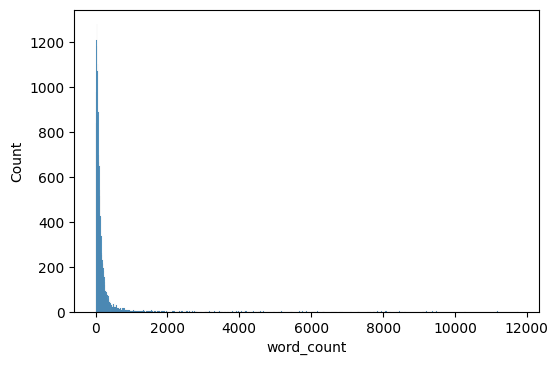

In [74]:
sns.histplot(df_pointone.word_count)

<AxesSubplot:xlabel='word_count', ylabel='Count'>

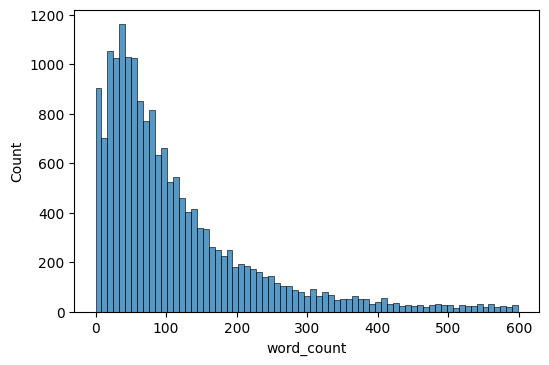

In [75]:
sns.histplot(df_pointone[df_pointone.word_count < 600].word_count)

In [77]:
print("Data without words: ", (df_pointone.word_count == 0).sum())

Data without words:  519


As we promise, we'll talk more about stop words and punctuations here. 

In [88]:
df_pointone["stop_word_count"] = df_pointone.text.apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_pointone["stop_word_ratio"] = df_pointone.stop_word_count / df_pointone.word_count
df.stop_word_ratio.fillna(0, inplace=True)

In [89]:
print(f"Median: {df_pointone.stop_word_ratio.median()}")
print(f"Mean  : {df_pointone.stop_word_ratio.mean()}")
print(f"Std   : {df_pointone.stop_word_ratio.std()}")

Median: 0.48
Mean  : 0.4617719731439063
Std   : 0.10352860063027619


<AxesSubplot:xlabel='stop_word_ratio', ylabel='Count'>

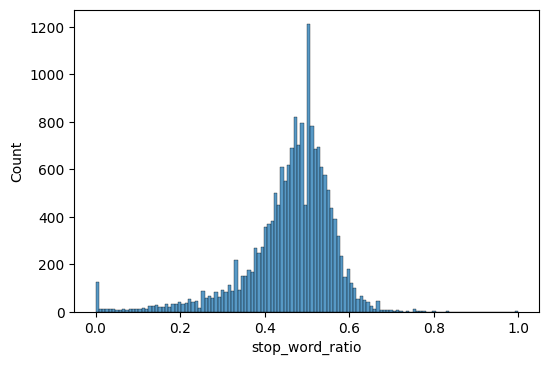

In [92]:
sns.histplot(df_pointone.stop_word_ratio)

<AxesSubplot:xlabel='punctuation_ratio', ylabel='Count'>

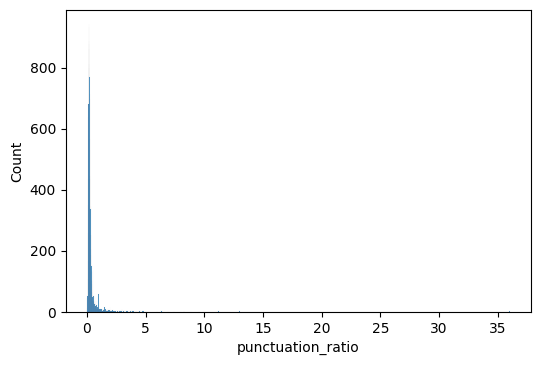

In [95]:
df_pointone["punctuation_count"] = df_pointone.text.apply(
    lambda x: len([c for c in str(x) if c in string.punctuation]))
df_pointone["punctuation_ratio"] = df_pointone.punctuation_count / df_pointone.word_count
sns.histplot(df_pointone.punctuation_ratio)

<AxesSubplot:xlabel='punctuation_ratio', ylabel='Count'>

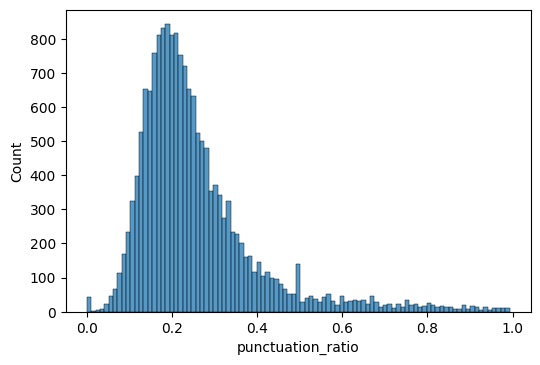

In [96]:
g = df_pointone.punctuation_ratio
sns.histplot(df_pointone[g < 1].punctuation_ratio)

It's not the most satisfied, but we shall call it a day. 